**NEWS HEADLINES DATASET FOR SARCASM DETECTION PART 2**

*In this part we will build the module for toidentify sarcastic sentences.*

***Plan to work:***

        >>> Load and preprocess data  
   
        >>> Define the Deep Lerning models 
       
        >>> Get the best model to solve the problem 
       
        >>> Save model. 

**Import library necessary**

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from keras.callbacks import History

In [33]:
import nltk
#nltk.download()

**Reading the Data**

In [34]:
# load the data
data = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [35]:
# view the data
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [36]:
# shape of the data
data.shape

(28619, 3)

In [37]:
# check th columns names
data.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [38]:
# check the data types in the columns
data.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

In [39]:
#checking the unique values in 'is_sarcastic' column
data.is_sarcastic.unique()

array([1, 0], dtype=int64)

In [40]:
#checking the value counts in 'is_sarcastic' column
data.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [41]:
# check the null values in data
data.isna().sum() 

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [42]:
# drop 'article_link' column
data = data.drop('article_link', axis=1)

In [43]:
#ckeck the data
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [44]:
data_len = data['headline'].apply(lambda x: len(x.split(' '))).sum()
print(f'We have {data_len} words in the headline')

We have 287674 words in the headline


In [45]:
data['headline'][5505:5510]

5505    terrifying server whole-heartedly cares about ...
5506    pennsylvania diocese releases names of 51 cler...
5507    cupid cop gave out roses, cards on valentine's...
5508                             to my muslim best friend
5509    ted cruz probably can't save the gop establish...
Name: headline, dtype: object

***Text pre-processing***

For the text cleaning we can use a some libreries as nltk and spacy. 

In [46]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy
import string
import re

nlp = spacy.load('en_core_web_sm')  #load spacy
stop_words = set(stopwords.words('english')) # get the english stropwords
def text_clean(text):                        #define function for clean the data  
    doc = nlp(text)
    lem_tok = [token.lemma_ for token in doc] # tokenize the words using spacy
    lem_al = [lemma.lower() for lemma in lem_tok if lemma.isalpha() and lemma not in stop_words]
    lem_text = ' '.join(lem_al)
    return lem_text

data['headline'] = data['headline'].apply(text_clean)

In [47]:
data_len = data['headline'].apply(lambda x: len(x.split(' '))).sum()
print(f'We have {data_len} words in the headline')

We have 204866 words in the headline


In [48]:
text = data['headline'].tolist()
labels = data['is_sarcastic'].tolist()

*Split, tokenize and padding the text with keras*

In [49]:
max_words = 10000 # max number of words in 
max_length = 200 # max length
trunc_type='post' # types of padding
padding_type='post'
oov_tok = "<OOV>"  # out-of-vocab
training_size = 20000 # size of training data

In [50]:
# split the dataset into training and testing datasets 
x_train = text[0:training_size]
x_test = text[training_size:]
y_train  = labels[0:training_size]
y_test  = labels[training_size:]

from sklearn.preprocessing import LabelEncoder
# label encode the target variable 
encoder = LabelEncoder()
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_test)

In [51]:
#import library for tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token = Tokenizer(num_words=max_words, oov_token=oov_tok)
token.fit_on_texts(x_train)
word_index = token.word_index

# Transforming train_text to a sequence of integers
train_seq = token.texts_to_sequences(x_train)             

# Pading train_sequences to the same length
train_pad = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type) 

# Transforming test_text to a sequence of integers
test_seq = token.texts_to_sequences(x_test) 

# Pading test_sequences to the same length
test_pad = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [52]:
# conwert the data into numpy array
x_train = np.array(train_pad)
y_train = np.array(train_y)
x_test  = np.array(test_pad)
y_test  = np.array(valid_y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape #check the shapes
print(x_train.dtype) # check the type of train values

int32


***Modeling the data***

*TensorFlow*

In [53]:
#import the library
from keras.models import Sequential
from keras.layers import Dense

#using Sequential model and Dense layer for biulding the first model
model_0 = Sequential()
model_0.add(Dense(8, activation='sigmoid'))
model_0.add(Dense(1))
history_0 = History()
#getting an optimizer with SGD
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#compile the model
model_0.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#fit the model
history_0 = model_0.fit(x_train, y_train, epochs=10, batch_size=32,verbose=2)

Epoch 1/10
625/625 - 2s - loss: 7.2790 - accuracy: 0.5234 - 2s/epoch - 3ms/step
Epoch 2/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 3/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 4/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 5/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 6/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 7/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 8/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 9/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step
Epoch 10/10
625/625 - 1s - loss: 7.3569 - accuracy: 0.5231 - 1s/epoch - 2ms/step


In [54]:
# evaluate the model
model_0.evaluate(x_test,y_test)

270/270 [==============================] - 1s 2ms/step - loss: 7.3286 - accuracy: 0.5249


[7.328596115112305, 0.5248869061470032]

In [55]:
# make a prediction
pred = model_0.predict(x_test)
print(pred)

[[-5.1902637]
 [-5.39772  ]
 [-5.478161 ]
 ...
 [-5.1902637]
 [-5.39772  ]
 [-5.1902637]]


In [56]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)
padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_0 = model_0.predict(padded)
print(pred_0)

[[-5.1902637]
 [-5.478161 ]]


Using Embedding and GlobalAveragePooling1D layers

In [57]:
from keras.models import Sequential
from keras.layers import Dense,Embedding, GlobalAveragePooling1D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# define function for lerning rate schedule 
def scheduler(epoch, lr): 
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

# max number of words to use into model
max_words = 10000
# max embedding number
embedding_dim = 50
# number epochs to use
max_epochs = 10 
# Add Embedding and GlobalAveragePooling1D layers in model
model_1 = Sequential() 
model_1.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_1.add(GlobalAveragePooling1D())
model_1.add(Dense(24, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

#compile the model 
model_1.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

#summarize the model
model_1.summary()

#saving the model
save_model1 = model_1.save("/models/model_1")
l_rate = LearningRateScheduler(scheduler)
# fit the model
history_1 = model_1.fit(x_train, y_train, 
                    epochs=max_epochs,
                    batch_size=32,
                    callbacks=[l_rate], 
                    validation_data=(x_test, y_test), 
                    verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           500000    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 24)                1224      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 501,249
Trainable params: 501,249
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /models/model_1\assets
Epoch 1/10
625/625 - 6s - loss: 0.6921 - accuracy: 0.523

In [114]:
# model evaluation
train_gru_results =model_1.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_1.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for Emb_GlobalAv: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  Emb_GlobalAv: {test_gru_results[1]*100:0.2f}')

Train accuracy for Emb_GlobalAv: 52.31
Test accuracy for  Emb_GlobalAv: 52.49


In [59]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_1 = model_1.predict(padded)
print(pred_1)

[[0.47617975]
 [0.47665116]]


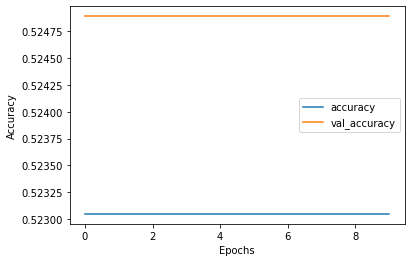

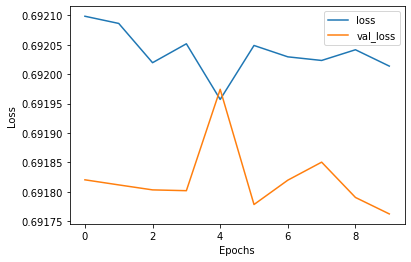

In [60]:
#plot the accuracy
plt.plot(history_1.history['accuracy'], label = "accuracy")
plt.plot(history_1.history['val_accuracy'], label = "val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_1.history['loss'], label = "loss")
plt.plot(history_1.history['val_loss'], label = "val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

*Using the Adam optimizer*

In [61]:
from tensorflow import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr): # define function for lerning rate schedule 
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

max_epochs = 15 #number epochs to use
Adam_history = History()
model_2 = Sequential()
model_2.add(Dense(100, activation="sigmoid",input_shape =(x_train.shape[1],)))
model_2.add(Dense(50,activation="sigmoid"))
model_2.add(Dense(10,activation="sigmoid"))
model_2.add(Dense(1,activation="sigmoid"))
model_2.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_2.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

# save the model
save_model_2 = model_2.save("/models/model_2") 
l_rate = LearningRateScheduler(scheduler)

Adam_history = model_2.fit(x_train, y_train, 
                    epochs=max_epochs,
                    batch_size=32,
                    callbacks=[l_rate],
                    validation_data=(x_test, y_test),
                    verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 10)                510       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 25,671
Trainable params: 25,671
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /models/model_2\assets
Epoch 1/15
625/625 - 7s - loss: 0.6824 - accuracy: 0.5584 - val_loss: 0.6777 - val_accuracy: 0.5680 - lr: 0.0010 - 7s/epoch 

In [113]:
# model evaluation
train_gru_results =model_2.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_2.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for SeqDense: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  SeqDense: {test_gru_results[1]*100:0.2f}')

Train accuracy for SeqDense: 59.17
Test accuracy for  SeqDense: 57.11


In [115]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_2 = model_2.predict(padded)
print(pred_2)

[[0.38186264]
 [0.4443144 ]]


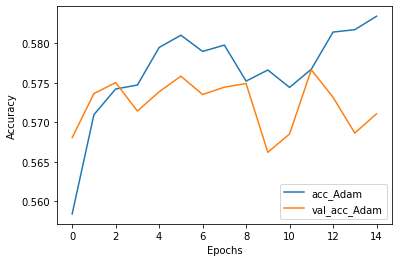

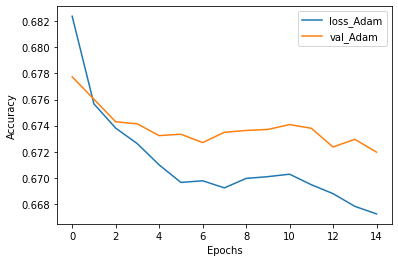

In [63]:
plt.plot(Adam_history.history['accuracy'], label = "acc_Adam")
plt.plot(Adam_history.history['val_accuracy'], label = "val_acc_Adam")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(Adam_history.history['loss'], label = "loss_Adam")
plt.plot(Adam_history.history['val_loss'], label = "val_Adam")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [65]:
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.callbacks import History


max_epochs = 20 #number epochs to use

history_3 = History()
model_3 = Sequential()
model_3.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(1))
model_3.add(Dropout(.1))
model_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_3.summary()
save_model3 = model_3.save("/models/model_3") # saving model
l_rate = LearningRateScheduler(scheduler)

history_3 = model_3.fit(x_train, y_train, 
                    epochs=max_epochs,batch_size=32, 
                    validation_data=(x_test, y_test),
                    callbacks=[l_rate],
                    verbose=2)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           500000    
                                                                 
 dense_10 (Dense)            (None, 200, 128)          6528      
                                                                 
 dense_11 (Dense)            (None, 200, 1)            129       
                                                                 
 dropout (Dropout)           (None, 200, 1)            0         
                                                                 
Total params: 506,657
Trainable params: 506,657
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /models/model_3\assets
Epoch 1/20
625/625 - 37s - loss: 1.3745 - accuracy: 0.5125 - val_loss: 0.7111 - val_accuracy: 0.5249 - lr: 0.0010 - 37s/ep

In [112]:
# model evaluation
train_gru_results =model_3.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_3.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for Seq_Embd: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  Seq_Embd: {test_gru_results[1]*100:0.2f}')

Train accuracy for Seq_Embd: 52.31
Test accuracy for  Seq_Embd: 52.49


In [117]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_3 = model_3.predict(padded)
print(pred_3)

[[[0.40534323]
  [0.43847445]
  [0.4270319 ]
  [0.40886226]
  [0.40892246]
  [0.4243759 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.4224148 ]
  [0.42241

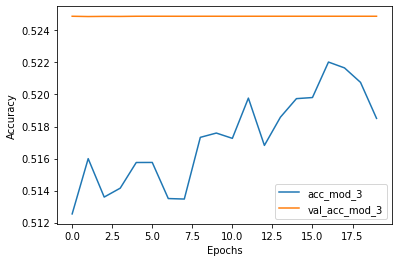

In [67]:
plt.plot(history_3.history['accuracy'], label = "acc_mod_3")
plt.plot(history_3.history['val_accuracy'], label = "val_acc_mod_3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

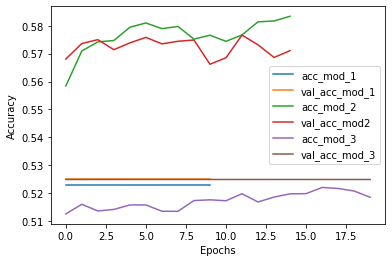

In [68]:

plt.plot(history_1.history['accuracy'], label = "acc_mod_1")
plt.plot(history_1.history['val_accuracy'], label = "val_acc_mod_1")

plt.plot(Adam_history.history['accuracy'], label = "acc_mod_2")
plt.plot(Adam_history.history['val_accuracy'], label = "val_acc_mod2")

plt.plot(history_3.history['accuracy'], label = "acc_mod_3")
plt.plot(history_3.history['val_accuracy'], label = "val_acc_mod_3")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [69]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

max_epochs = 10 #number epochs to use

model_4 = Sequential()
model_4.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_4.add(GlobalAveragePooling1D())
model_4.add(Dense(150, activation='relu'))
model_4.add(Dense(100, activation='relu'))
model_4.add(Dense(50, activation='sigmoid'))
model_4.add(Dropout(.2))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_4.summary()

save_model4 = model_4.save("/models/model_4") # saving model

history_4 = model_4.fit(x_train, y_train, 
                    epochs=max_epochs,
                    batch_size=32, 
                    validation_data=(x_test, y_test),
                    verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           500000    
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 150)               7650      
                                                                 
 dense_13 (Dense)            (None, 100)               15100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                      

In [111]:
# model evaluation
train_gru_results =model_4.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_4.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for GlobalAv: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  GlobalAv: {test_gru_results[1]*100:0.2f}')

Train accuracy for GlobalAv: 92.02
Test accuracy for  GlobalAv: 77.45


In [118]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_4 = model_4.predict(padded)
print(pred_4)

[[0.01881319]
 [0.9934243 ]]


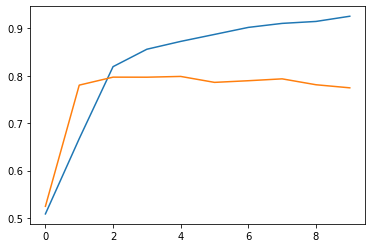

In [71]:
plt.plot(history_4.history['accuracy'], label = "acc_mod_4")
plt.plot(history_4.history['val_accuracy'], label = "val_acc_mod_4")

Using the GlobalAveragePooling1D & Convolution1D layers

In [72]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Convolution1D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# define the function for lerning rate schedule 

max_epochs = 10 # number epochs to use

model_5 = Sequential()  # define the model
model_5.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_5.add(Convolution1D(100,3, activation='relu'))  # add the convolutional Layer
model_5.add(GlobalAveragePooling1D())                 # add the average polling
model_5.add(Dense(50, activation='relu'))             # add the dense layers
model_5.add(Dropout(.1))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # compile the model

model_5.summary() # model summarize

save_model5 = model_5.save("/models/model_5") # saving model

# fit the model
history_5 = model_5.fit(x_train, y_train, 
                    epochs=max_epochs,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    verbose=2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 50)           500000    
                                                                 
 conv1d (Conv1D)             (None, 198, 100)          15100     
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                      

In [110]:
# model evaluation
train_gru_results =model_5.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_5.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for Conv: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  Conv: {test_gru_results[1]*100:0.2f}')

Train accuracy for Conv: 99.20
Test accuracy for  Conv: 76.92


In [120]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_5 = model_5.predict(padded)
print(pred_5)

[[9.4392896e-04]
 [9.9999857e-01]]


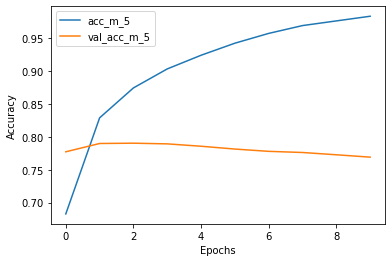

In [74]:
plt.plot(history_5.history['accuracy'], label = "acc_m_5")
plt.plot(history_5.history['val_accuracy'], label = "val_acc_m_5")
#
#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_m_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_m2")
#
#plt.plot(history_4.history['accuracy'], label = "acc_mod_4")
#plt.plot(history_4.history['accuracy'], label = "val_acc_mod_4")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

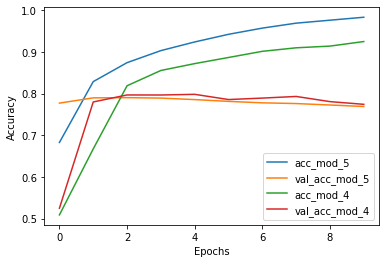

In [75]:
plt.plot(history_5.history['accuracy'], label = "acc_mod_5")
plt.plot(history_5.history['val_accuracy'], label = "val_acc_mod_5")

#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_mod_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_mod2")
#
plt.plot(history_4.history['accuracy'], label = "acc_mod_4")
plt.plot(history_4.history['val_accuracy'], label = "val_acc_mod_4")
#

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Using EarlyStopping

In [76]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Convolution1D, Dropout
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

  
max_epochs = 10 # number epochs to use

model_6 = Sequential()  # define the model
model_6.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_6.add(Convolution1D(100,3, activation='relu'))  # add the convolutional Layer
model_6.add(GlobalAveragePooling1D())                 # add the average polling
model_6.add(Dense(50, activation='relu'))             # add the dense layers
model_6.add(Dropout(0.25))                            # add the drop out layer
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # compile the model

model_6.summary() # model summarize

save_model6 = model_6.save("/models/model_6") # saving model

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True)

# fit the model
history_6 = model_6.fit(x_train, y_train, 
                        epochs=max_epochs,
                        batch_size=32, 
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping],
                        verbose=2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           500000    
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 100)          15100     
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                      

In [109]:
# model evaluation
train_gru_results =model_6.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_6.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for Conv_EarlSTOP: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  Conv_EarlSTOP: {test_gru_results[1]*100:0.2f}')

Train accuracy for Conv_EarlSTOP: 89.90
Test accuracy for  Conv_EarlSTOP: 79.36


In [122]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_6 = model_6.predict(padded)
print(pred_6)

[[0.11320841]
 [0.97000694]]


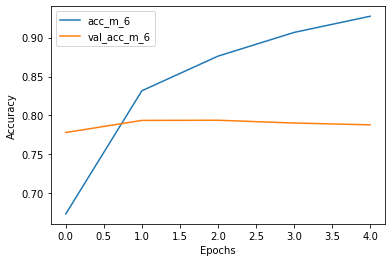

In [78]:
plt.plot(history_6.history['accuracy'], label = "acc_m_6")
plt.plot(history_6.history['val_accuracy'], label = "val_acc_m_6")
#
#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_m_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_m2")
#
#plt.plot(history_5.history['accuracy'], label = "acc_mod_5")
#plt.plot(history_5.history['accuracy'], label = "val_acc_mod_5")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**SimpleRNN**

In [79]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Convolution1D, Dropout, SimpleRNN
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping


max_epochs = 10 # number epochs to use

model_7 = Sequential()  # define the model
model_7.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_7.add(SimpleRNN(64, return_sequences=True)) # add the RNN Layer
model_7.add(SimpleRNN(32))  
model_7.add(Dense(32, activation='relu'))             # add the dense layers   
model_7.add(Dropout(0.25)) 
model_7.add(Dense(1, activation='sigmoid'))

# compile the mode
model_7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_7.summary() # model summarize

save_model_7 = model_7.save("/models/model_7") # saving model

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True)
# fit the model
history_7 = model_7.fit(x_train, y_train, 
                        epochs=max_epochs,
                        batch_size=32, 
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping],
                        verbose=2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 50)           500000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 64)           7360      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 511,553
Trainable params: 511,553
Non-tr

In [106]:
# model evaluation
train_gru_results =model_7.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_7.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for SRNN: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  SRNN: {test_gru_results[1]*100:0.2f}')

Train accuracy for SRNN: 55.79
Test accuracy for  SRNN: 55.23


In [123]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_7 = model_7.predict(padded)
print(pred_7)

[[0.44518036]
 [0.54741526]]


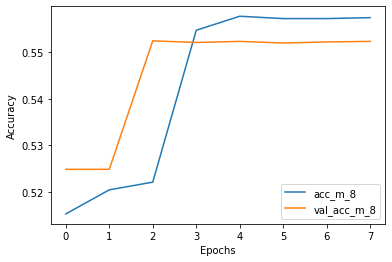

In [81]:
plt.plot(history_7.history['accuracy'], label = "acc_m_8")
plt.plot(history_7.history['val_accuracy'], label = "val_acc_m_8")
#
#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_m_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_m2")
#
#plt.plot(history_5.history['accuracy'], label = "acc_mod_5")
#plt.plot(history_5.history['accuracy'], label = "val_acc_mod_5")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**SimpleRNN & Bidirectional**

In [82]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Convolution1D, Dropout, SimpleRNN, Bidirectional
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

max_epochs = 30 # number epochs to use

model_8 = Sequential()  # define the model
model_8.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_8.add(Bidirectional(SimpleRNN(64, return_sequences=True))) # add the RNN Layer
model_8.add(SimpleRNN(32))  
model_8.add(Dense(32, activation='relu'))             # add the dense layers                   
model_8.add(Dense(1, activation='sigmoid'))

# compile the mode
model_8.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_8.summary() # model summarize

save_model8 = model_8.save("/models/model_9") # saving model

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True)
# fit the model
history_8 = model_8.fit(x_train, y_train, 
                        epochs=max_epochs,
                        batch_size=32, 
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping],
                        verbose=2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 50)           500000    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         14720     
 l)                                                              
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 520,961
Trainable params: 520,961
Non-trainable params: 0
________________________________________________

In [107]:
# model evaluation
train_gru_results =model_8.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_8.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for Bidirectional: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  Bidirectional: {test_gru_results[1]*100:0.2f}')

Train accuracy for Bidirectional: 54.28
Test accuracy for  Bidirectional: 54.19


In [124]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_8 = model_8.predict(padded)
print(pred_8)

[[0.4593295]
 [0.5541181]]


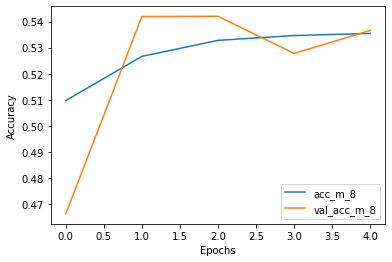

In [84]:
plt.plot(history_8.history['accuracy'], label = "acc_m_8")
plt.plot(history_8.history['val_accuracy'], label = "val_acc_m_8")
#
#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_m_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_m2")
#
#plt.plot(history_5.history['accuracy'], label = "acc_mod_5")
#plt.plot(history_5.history['accuracy'], label = "val_acc_mod_5")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**LSTM**

In [85]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Convolution1D, Dropout, LSTM
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

max_epochs = 10 # number epochs to use

model_9 = Sequential()  # define the model
model_9.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_9.add(LSTM(100, activation='sigmoid'))    # add the Long Short-Term Memory Layer
model_9.add(Dense(50, activation='relu'))             # add the dense layers
model_9.add(Dropout(0.5))                            # add the drop out layer
model_9.add(Dense(1, activation='sigmoid'))

model_9.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # compile the model

model_9.summary() # model summarize

save_model9 = model_9.save("/models/model_9") # saving model
#lrate = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True)

# fit the model
history_9 = model_9.fit(x_train, y_train, 
                          epochs=max_epochs,
                          batch_size=32,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stopping],
                          verbose=2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 50)           500000    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_24 (Dense)            (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 565,501
Trainable params: 565,501
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /models/mode

Epoch 1/10
625/625 - 95s - loss: 0.6937 - accuracy: 0.5212 - val_loss: 0.6922 - val_accuracy: 0.5249 - 95s/epoch - 152ms/step
Epoch 2/10
625/625 - 104s - loss: 0.6922 - accuracy: 0.5231 - val_loss: 0.6919 - val_accuracy: 0.5249 - 104s/epoch - 166ms/step
Epoch 3/10
625/625 - 99s - loss: 0.6921 - accuracy: 0.5231 - val_loss: 0.6919 - val_accuracy: 0.5249 - 99s/epoch - 159ms/step
Epoch 4/10
625/625 - 98s - loss: 0.6921 - accuracy: 0.5231 - val_loss: 0.6919 - val_accuracy: 0.5249 - 98s/epoch - 157ms/step
Epoch 5/10
625/625 - 96s - loss: 0.6921 - accuracy: 0.5231 - val_loss: 0.6919 - val_accuracy: 0.5249 - 96s/epoch - 153ms/step


In [104]:
# model evaluation
train_gru_results =model_9.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_9.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for LSTM: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for  LSTM: {test_gru_results[1]*100:0.2f}')

Train accuracy for LSTM: 52.31
Test accuracy for  LSTM: 52.49


In [125]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_9 = model_9.predict(padded)
print(pred_9)

[[0.47676355]
 [0.47676355]]


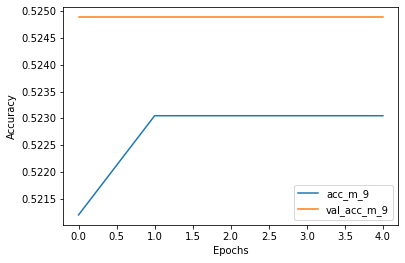

In [87]:
plt.plot(history_9.history['accuracy'], label = "acc_m_9")
plt.plot(history_9.history['val_accuracy'], label = "val_acc_m_9")
#
#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_m_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_m2")
#
#plt.plot(history_5.history['accuracy'], label = "acc_mod_5")
#plt.plot(history_5.history['accuracy'], label = "val_acc_mod_5")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**GRU**

In [88]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, GRU
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

max_epochs = 10 #number epochs to use

model_10 = Sequential()
model_10.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_10.add(GRU(50, activation='tanh',  return_sequences=True))
model_10.add(Flatten())
model_10.add(Dense(25, activation='relu'))
model_10.add(Dropout(0.25))
model_10.add(Dense(1, activation='sigmoid'))

model_10.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_10.summary()

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True)

save_model_10 = model_10.save("/models/model_10") # saving model
lrate = LearningRateScheduler(scheduler)

history_10 = model_10.fit(x_train, y_train, 
                    epochs=max_epochs,
                          batch_size=32,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stopping],
                          verbose=2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 50)           500000    
                                                                 
 gru (GRU)                   (None, 200, 50)           15300     
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_26 (Dense)            (None, 25)                250025    
                                                                 
 dropout_6 (Dropout)         (None, 25)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 765,351
Trainable params: 765,351
Non-t

INFO:tensorflow:Assets written to: /models/model_10\assets


INFO:tensorflow:Assets written to: /models/model_10\assets


Epoch 1/10
625/625 - 52s - loss: 0.5330 - accuracy: 0.7139 - val_loss: 0.4282 - val_accuracy: 0.8009 - 52s/epoch - 83ms/step
Epoch 2/10
625/625 - 48s - loss: 0.3129 - accuracy: 0.8687 - val_loss: 0.4279 - val_accuracy: 0.8013 - 48s/epoch - 76ms/step
Epoch 3/10
625/625 - 48s - loss: 0.2084 - accuracy: 0.9182 - val_loss: 0.5068 - val_accuracy: 0.7966 - 48s/epoch - 77ms/step
Epoch 4/10
625/625 - 48s - loss: 0.1476 - accuracy: 0.9452 - val_loss: 0.6008 - val_accuracy: 0.7897 - 48s/epoch - 76ms/step
Epoch 5/10
625/625 - 47s - loss: 0.0956 - accuracy: 0.9661 - val_loss: 0.8057 - val_accuracy: 0.7808 - 47s/epoch - 76ms/step


In [103]:
# model evaluation
train_gru_results =model_10.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_10.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for GRU: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for GRU : {test_gru_results[1]*100:0.2f}')

Train accuracy for GRU: 87.96
Test accuracy for GRU : 80.14


In [126]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_10 = model_10.predict(padded)
print(pred_10)

[[0.1932449]
 [0.9334065]]


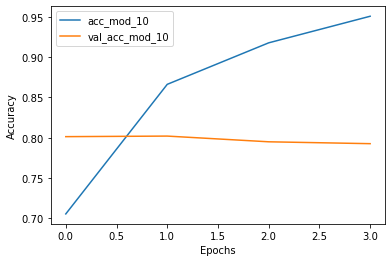

In [136]:
plt.plot(history_10.history['accuracy'], label = "acc_mod_10")
plt.plot(history_10.history['val_accuracy'], label = "val_acc_mod_10")

#plt.plot(Adam_history.history['binary_accuracy'], label = "acc_mod_2")
#plt.plot(Adam_history.history['val_binary_accuracy'], label = "val_acc_mod2")
#
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [100]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, GRU
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# define function for lerning rate schedule 
def scheduler(epoch, lr): 
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

max_epochs = 50 #number epochs to use

model_11 = Sequential()
model_11.add(Embedding(max_words, embedding_dim, input_length = max_length))
model_11.add(GRU(100, activation='tanh',  return_sequences=True))
model_11.add(Flatten())
model_11.add(Dense(50, activation='relu'))
model_11.add(Dropout(0.25))
model_11.add(Dense(1, activation='sigmoid'))

model_11.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_11.summary()

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3, 
                               restore_best_weights=True)

save_model_11 = model_11.save("/models/model_11") # saving model


history_11 = model_11.fit(x_train, y_train, 
                    epochs=max_epochs,
                          batch_size=32,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stopping],
                          verbose=2)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 50)           500000    
                                                                 
 gru_3 (GRU)                 (None, 200, 100)          45600     
                                                                 
 flatten_3 (Flatten)         (None, 20000)             0         
                                                                 
 dense_34 (Dense)            (None, 50)                1000050   
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,545,701
Trainable params: 1,545,701
N

INFO:tensorflow:Assets written to: /models/model_11\assets


INFO:tensorflow:Assets written to: /models/model_11\assets


Epoch 1/50
625/625 - 79s - loss: 0.5043 - accuracy: 0.7391 - val_loss: 0.4131 - val_accuracy: 0.8066 - 79s/epoch - 126ms/step
Epoch 2/50
625/625 - 99s - loss: 0.2932 - accuracy: 0.8753 - val_loss: 0.4236 - val_accuracy: 0.8074 - 99s/epoch - 158ms/step
Epoch 3/50
625/625 - 81s - loss: 0.1841 - accuracy: 0.9274 - val_loss: 0.5149 - val_accuracy: 0.7938 - 81s/epoch - 129ms/step
Epoch 4/50
625/625 - 80s - loss: 0.1116 - accuracy: 0.9599 - val_loss: 0.6554 - val_accuracy: 0.7894 - 80s/epoch - 128ms/step


In [102]:
# model evaluation
train_gru_results =model_11.evaluate(x_train, y_train, verbose=0, batch_size=32)
test_gru_results = model_11.evaluate(x_test, y_test, verbose=0, batch_size=32)
print(f'Train accuracy for GRU: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy for GRU : {test_gru_results[1]*100:0.2f}')

Train accuracy for GRU: 90.18
Test accuracy for GRU : 80.66


In [127]:
#check the model
sentences = ['lesbian consider father indiana amazing one', "terrifying server whole heartedly care guest dining experience"]
sequencess = token.texts_to_sequences(sentences)

padded = pad_sequences(sequencess, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# make a prediction
pred_11= model_11.predict(padded)
print(pred_11)

[[0.12063676]
 [0.9569127 ]]


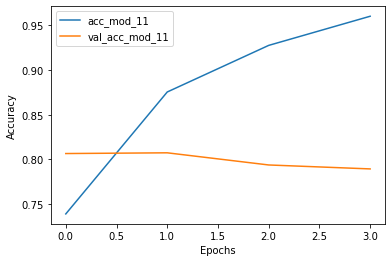

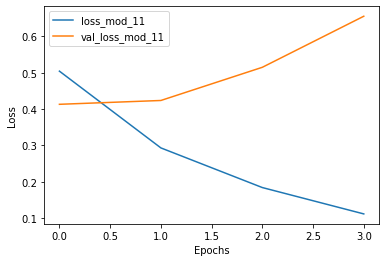

In [139]:
plt.plot(history_11.history['accuracy'], label = "acc_mod_11")
plt.plot(history_11.history['val_accuracy'], label = "val_acc_mod_11")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_11.history['loss'], label = "loss_mod_11")
plt.plot(history_11.history['val_loss'], label = "val_loss_mod_11")


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [129]:
pred_GRU = model_11.predict(x_test)

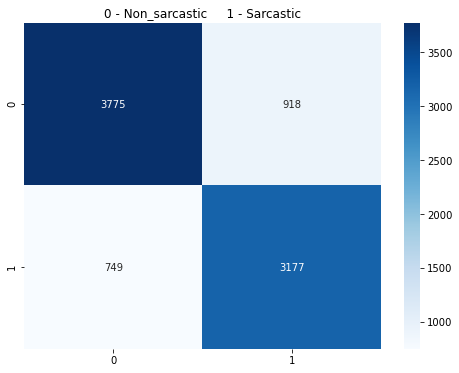

In [133]:
from sklearn.metrics import confusion_matrix,classification_report
conf_mtx=confusion_matrix(pred_GRU.round(), y_test)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mtx,annot=True,fmt='d',cmap='Blues')
plt.title("0 - Non_sarcastic     1 - Sarcastic")
plt.show()

In [134]:
(3775+3177)/(3775+918+3177+749) #check accuracy with confusion matrix result

0.8065900916579649